Epoch 1/20, Loss: 0.06806956976652145
Epoch 2/20, Loss: 0.009126308374106884
Epoch 3/20, Loss: 0.006137156393378973
Epoch 4/20, Loss: 0.006713492330163717
Epoch 5/20, Loss: 0.0003526262007653713
Epoch 6/20, Loss: 0.00020306865917518735
Epoch 7/20, Loss: 8.281407644972205e-05
Epoch 8/20, Loss: 0.002169228857383132
Epoch 9/20, Loss: 0.0006346043082885444
Epoch 10/20, Loss: 0.002735432703047991
Epoch 11/20, Loss: 2.1866675524506718e-05
Epoch 12/20, Loss: 0.00010820379975484684
Epoch 13/20, Loss: 0.0003116309526376426
Epoch 14/20, Loss: 4.520460788626224e-05
Epoch 15/20, Loss: 1.3604386367660481e-05
Epoch 16/20, Loss: 3.3029486075975e-05
Epoch 17/20, Loss: 3.1150984796113335e-06
Epoch 18/20, Loss: 6.7790156208502594e-06
Epoch 19/20, Loss: 7.384287528111599e-06
Epoch 20/20, Loss: 4.639638973458204e-06


<ipython-input-1-5832aead2bb2>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/optimized_lstm_model.pth'))


Confusion Matrix:
[[855   1]
 [  3 287]]
F1 Score: 0.9930795847750865
Accuracy: 0.9965095986038395


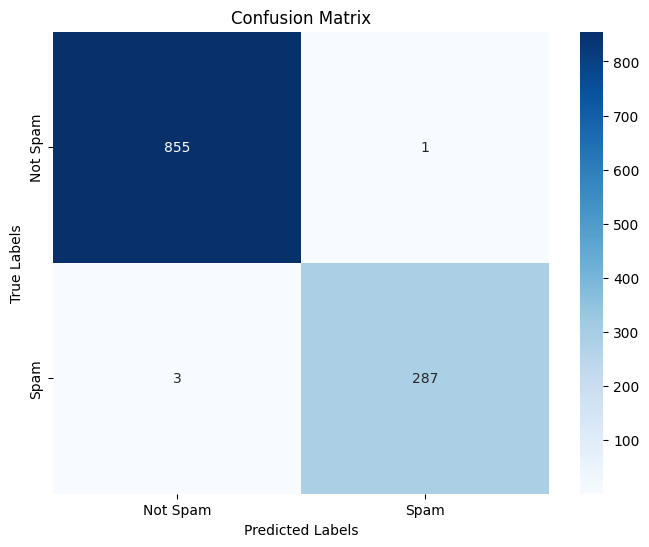

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset
emails_data = pd.read_excel('/content/emails.xlsx')  # Path to the uploaded file

# Step 2: Preprocess the data
texts = emails_data['text'].values
labels = emails_data['spam'].values

# Convert text to numeric using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Limit to 5000 features
X = vectorizer.fit_transform(texts).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 3: Create a custom dataset
class EmailDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmailDataset(X_train_tensor, y_train_tensor)
test_dataset = EmailDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Optimized batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 4: Define the LSTM model with optimizations
class OptimizedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(OptimizedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x[:, -1, :])  # Apply ReLU activation to the last LSTM output
        x = self.fc(x)
        return x

input_size = X_train.shape[1]
hidden_size = 256  # Increased hidden size
output_size = 2
num_layers = 2  # Multi-layer LSTM

model = OptimizedLSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Optimized learning rate

# Step 5: Train the model
num_epochs = 20  # Increased number of epochs
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Step 6: Save the model
torch.save(model.state_dict(), '/content/optimized_lstm_model.pth')

# Step 7: Load the model and evaluate
model.load_state_dict(torch.load('/content/optimized_lstm_model.pth'))
model.eval()

# Evaluate on test data
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

# Step 8: Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Step 9: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
